In [ ]:
!pip install torch==2.7.1+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install pydantic-ai pydantic
!pip install "pydantic-ai-slim[huggingface]"
!pip install typing_extensions --upgrade
!pip install "transformers>=4.47.0"
!pip install "huggingface-hub>=0.26.0,<1.0"
!pip install gradio

In [ ]:
import torch
print(torch.__version__)

2.7.1+cu118


In [ ]:
from pydantic import BaseModel, Field, ValidationError

Zadanie do zrobienia:

## NBA Assistant

W ramach zadania stworzyłem interaktywny system inteligentnego agenta wykorzystujący bibliotekę PydanticAI, model językowy z HuggingFace oraz dane z oficjalnego NBA API. Zadaniem agenta jest odpowiadanie na pytania użytkownika dotyczące NBA, takie jak wyszukiwanie zawodników, statystyk, wyników meczów czy tabeli ligowej. System wykorzystuje modele Pydantic do walidowania odpowiedzi, dzięki czemu zwracane dane są zawsze poprawnie ustrukturyzowane i zgodne z oczekiwanym formatem.
Przygotowałem kilka narzędzi (tools), które agent może wywoływać między innymi pobieranie zawodników drużyny, statystyk zawodnika, wyników meczów z określonego dnia oraz tabeli konferencji. Każde z tych narzędzi zwraca prawdziwe dane z zewnętrznego API, a agent jest zobowiązany korzystać z nich w trakcie generowania odpowiedzi.
Następnie zbudowałem agenta PydanticAI, który łączy model językowy z dostarczonymi narzędziami oraz zdefiniowanymi schematami danych. Dzięki temu agent potrafi dynamicznie podejmować decyzje, wywoływać odpowiednie funkcje i zwracać spójną, kompleksową odpowiedź.
Na koniec przygotowałem interfejs użytkownika w Gradio, który umożliwia zadawanie pytań w formie czatu oraz wygodne prezentowanie wyników. Projekt wspiera różne typy zapytań, obsługę błędów oraz formatowanie danych, zapewniając przejrzysty i przyjazny sposób interakcji z agentem.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from pydantic_ai.models.huggingface import HuggingFaceModel
from pydantic_ai.providers.huggingface import HuggingFaceProvider

model = HuggingFaceModel(
    'moonshotai/Kimi-K2-Instruct',
    provider=HuggingFaceProvider(provider_name='together', api_key='wpisz wladny klucz API tutaj')
)


W tym fragmencie kodu przygotowuję model językowy, który będzie wykorzystywany przez agenta PydanticAI. Najpierw importuję potrzebne moduły z biblioteki Transformers oraz PydanticAI, aby móc korzystać z modeli HuggingFace w połączeniu z dostawcami API. Następnie tworzę obiekt HuggingFaceModel, wskazując na konkretny model (moonshotai/Kimi-K2-Instruct) dostępny na platformie HuggingFace.
Dodatkowo konfiguruję dostawcę (HuggingFaceProvider), który odpowiada za połączenie z usługą Together API i uwierzytelnienie poprzez klucz API. W efekcie powstaje kompletny obiekt modelu, który później wykorzystuję w agencie do interpretowania zapytań i generowania odpowiedzi.

In [ ]:
pip install nba_api

instalacja nba api

## Modele Pydantic dla NBA Agenta

In [ ]:
# MODELE PYDANTIC DLA NBA AGENT
from pydantic import BaseModel, Field
from typing import Optional, List

class PlayerStats(BaseModel):
    player_name: str
    team_name: str
    season: str
    games_played: int = Field(..., ge=0)
    points_per_game: float = Field(..., ge=0)
    assists_per_game: float = Field(..., ge=0)
    rebounds_per_game: float = Field(..., ge=0)

class PlayerInfo(BaseModel):
    player_id: int
    player_name: str
    team_name: str
    position: str
    jersey_number: int = Field(..., ge=0, le=99)

class MatchInfo(BaseModel):
    match_id: str
    home_team: str
    away_team: str
    game_date: str
    home_score: int = Field(..., ge=0)
    away_score: int = Field(..., ge=0)
    status: str

class StandingInfo(BaseModel):
    team_name: str
    conference: str
    wins: int = Field(..., ge=0)
    losses: int = Field(..., ge=0)
    win_percentage: float = Field(..., ge=0, le=1)
    position: int = Field(..., ge=1, le=30)

class NBASearchResult(BaseModel):
    """Główny model wyników NBA"""
    query: str
    result_type: str
    players: Optional[List[PlayerInfo]] = None
    matches: Optional[List[MatchInfo]] = None
    player_stats: Optional[PlayerStats] = None
    standings: Optional[List[StandingInfo]] = None
    summary: str

class NoResultsFound(BaseModel):
    """Brak wyników"""
    query: str
    reason: str
    suggestion: Optional[str] = None

W tej części zadania definiuję zestaw modeli Pydantic, które służą jako struktury danych wykorzystywane przez agenta NBA. Modele te pełnią kluczową rolę, ponieważ zapewniają walidację danych zwracanych przez narzędzia (tools) i wymuszają spójny format odpowiedzi. Każdy model reprezentuje inny typ informacji pobieranych z NBA API.
Model PlayerStats przechowuje statystyki wybranego zawodnika, takie jak punkty, asysty czy zbiórki na mecz. Model PlayerInfo opisuje podstawowe informacje o zawodniku, m.in. identyfikator, drużynę, pozycję i numer koszulki. Model MatchInfo reprezentuje dane o pojedynczym meczu nazwy drużyn, datę, wynik i status spotkania. Model StandingInfo przedstawia pozycję drużyny w tabeli konferencji wraz z bilansem zwycięstw.
Najważniejszym modelem jest NBASearchResult, który łączy wszystkie typy informacji i definiuje finalny format odpowiedzi agenta, zawierający wyniki zapytania oraz krótkie podsumowanie. Dodatkowo został zdefiniowany model NoResultsFound, który opisuje sytuację, w której narzędzia nie znalazły żadnych danych wraz z powodem i ewentualną sugestią dla użytkownika.

## Funkcje pomocnicze (TOOLSY) – NBA API

In [ ]:
# FUNKCJE POMOCNICZE (TOOLS) - NBA API
import pandas as pd
import datetime
import unicodedata
from typing import List, Optional
from nba_api.stats.static import teams, players
from nba_api.stats.endpoints import commonteamroster, scoreboardv2, playercareerstats, leaguestandingsv3

def _get_team_id(team_name: str) -> Optional[int]:
    nba_teams = teams.get_teams()
    match = next((t for t in nba_teams if t["full_name"].lower() == team_name.lower()), None)
    return match["id"] if match else None

def _get_team_name(team_id: int) -> Optional[str]:
    nba_teams = teams.get_teams()
    match = next((t for t in nba_teams if t["id"] == team_id), None)
    return match["full_name"] if match else None

def get_players_by_team(team_name: str) -> list:
    """Tool 1: Pobiera zawodników z drużyny"""
    team_id = _get_team_id(team_name)
    if not team_id:
        return []

    roster = commonteamroster.CommonTeamRoster(team_id=team_id)
    df = roster.get_data_frames()[0]

    players_list = []
    for _, row in df.iterrows():
        num = int(row["NUM"]) if pd.notna(row["NUM"]) else 0
        players_list.append({
            "player_id": int(row["PLAYER_ID"]),
            "player_name": row["PLAYER"],
            "team_name": team_name,
            "position": row["POSITION"],
            "jersey_number": num,
        })

    print(f"Pobrano {len(players_list)} zawodników z {team_name}")
    return players_list

def get_matches_by_date(date_str: str) -> list:
    """Tool 2: Pobiera mecze z konkretnej daty"""
    try:
        datetime.datetime.strptime(date_str, "%Y-%m-%d")
    except ValueError:
        return []

    sb = scoreboardv2.ScoreboardV2(game_date=date_str)
    df = sb.get_data_frames()[0]

    matches = []
    for _, row in df.iterrows():
        matches.append({
            "match_id": str(row["GAME_ID"]),
            "home_team": _get_team_name(row["HOME_TEAM_ID"]) or "Unknown",
            "away_team": _get_team_name(row["VISITOR_TEAM_ID"]) or "Unknown",
            "game_date": str(row["GAME_DATE_EST"])[:10],
            "home_score": int(row.get("PTS_home", 0)),
            "away_score": int(row.get("PTS_away", 0)),
            "status": row["GAME_STATUS_TEXT"]
        })

    print(f"Pobrano {len(matches)} meczów z daty {date_str}")
    return matches

def get_player_stats(player_name: str) -> dict:
    """Tool 3: Pobiera statystyki zawodnika"""
    def normalize_unicode(text):
        nfd = unicodedata.normalize('NFD', text)
        return ''.join(char for char in nfd if unicodedata.category(char) != 'Mn').strip().lower()

    player_name_norm = normalize_unicode(player_name)
    nba_players = players.get_players()

    match = None
    for p in nba_players:
        if normalize_unicode(p["full_name"]) == player_name_norm:
            match = p
            break

    if not match:
        for p in nba_players:
            if player_name_norm in normalize_unicode(p["full_name"]):
                match = p
                break

    if not match:
        print(f"Nie znaleziono: {player_name}")
        return None

    player_id = match["id"]
    career = playercareerstats.PlayerCareerStats(player_id=player_id)
    df = career.get_data_frames()[0]

    if df.empty:
        return None

    latest = df.iloc[-1]

    def safe_float(value, default=0.0):
        try:
            return float(value) if pd.notna(value) else default
        except:
            return default

    def safe_int(value, default=0):
        try:
            return int(value) if pd.notna(value) else default
        except:
            return default

    games_played = safe_int(latest["GP"], 1)

    result = {
        "player_name": match["full_name"],
        "team_name": str(latest["TEAM_NAME"]) if pd.notna(latest["TEAM_NAME"]) else "Unknown",
        "season": str(latest["SEASON_ID"]),
        "games_played": games_played,
        "points_per_game": round(safe_float(latest["PTS"]) / games_played, 1),
        "assists_per_game": round(safe_float(latest["AST"]) / games_played, 1),
        "rebounds_per_game": round(safe_float(latest["REB"]) / games_played, 1),
    }

    print(f"Statystyki: {result['player_name']}")
    return result

def get_standings_by_conference(conference: str = "East") -> list:
    """Tool 4: Pobiera tabelę konferencji"""
    try:
        current_year = datetime.datetime.now().year
        current_month = datetime.datetime.now().month

        if current_month >= 10:
            season = f"{current_year}-{str(current_year + 1)[2:]}"
        else:
            season = f"{current_year - 1}-{str(current_year)[2:]}"

        standings = leaguestandingsv3.LeagueStandingsV3(season=season, league_id='00')
        df = standings.get_data_frames()[0]

        if df.empty:
            return []

        conf = conference.capitalize()
        if conf not in ['East', 'West']:
            conf = 'East'

        df_filtered = df[df['Conference'] == conf].copy()
        df_filtered = df_filtered.sort_values('WinPCT', ascending=False).reset_index(drop=True)

        standings_list = []
        for idx, row in df_filtered.iterrows():
            standings_list.append({
                "team_name": str(row['TeamName']),
                "conference": str(row['Conference']),
                "wins": int(row['WINS']),
                "losses": int(row['LOSSES']),
                "win_percentage": round(float(row['WinPCT']), 3),
                "position": idx + 1
            })

        print(f"Pobrano {len(standings_list)} drużyn z {conf}")
        return standings_list

    except Exception as e:
        print(f" Błąd: {e}")
        return []

W tym fragmencie definiuję zestaw funkcji pełniących rolę narzędzi, z których agent PydanticAI może korzystać, aby pobierać prawdziwe dane z oficjalnego NBA API (nba_api). Każdy tool odpowiada za inny obszar informacji i zwraca dane w formacie, który później jest walidowany przez modele Pydantic.
Na początku znajdują się dwie funkcje pomocnicze _get_team_id oraz _get_team_name, które ułatwiają zamianę nazw drużyn na ich identyfikatory oraz odwrotnie. Są one wykorzystywane przez pozostałe narzędzia.
Pierwszy główny tool get_players_by_team pobiera pełną listę zawodników danej drużyny NBA na podstawie jej nazwy. Korzysta z endpointu commonteamroster i zwraca szczegółowe informacje o każdym graczu, takie jak ID, pozycja czy numer na koszulce.
Drugi tool get_matches_by_date pozwala sprawdzić wszystkie mecze rozegrane w konkretnej dacie. Po zweryfikowaniu poprawności formatu daty korzysta z endpointu scoreboardv2, a następnie zwraca listę meczów: drużynę gospodarzy i gości, wynik oraz status spotkania.
Trzeci tool get_player_stats odpowiada za pobranie najnowszych dostępnych statystyk zawodnika. Nazwa gracza jest dodatkowo normalizowana, aby uniknąć problemów z polskimi znakami i różnymi formatami zapisu. Dzięki endpointowi playercareerstats zwracane są dane takie jak punkty, asysty czy zbiórki na mecz.
Czwarty tool get_standings_by_conference pobiera aktualną tabelę konferencji Wschodniej lub Zachodniej. Funkcja automatycznie wylicza bieżący sezon NBA, a następnie pobiera i sortuje drużyny według procentu zwycięstw, generując pełną tabelę rankingową.
Każda z tych funkcji została zaprojektowana tak, aby zwracać czyste, gotowe do walidacji struktury danych lub pustą listę w przypadku braku wyników. Dzięki temu agent może w przewidywalny sposób korzystać z prawdziwych danych NBA w trakcie swojej pracy.

## PydanticAI + NBA API

In [ ]:
# AGENT PYDANTICAI Z PRAWDZIWYMI TOOLS
from pydantic_ai import Agent

nba_agent = Agent(
    model,  # Model HuggingFace
    output_type=NBASearchResult | NoResultsFound,

    tools=[
        get_players_by_team,
        get_matches_by_date,
        get_player_stats,
        get_standings_by_conference
    ],
    instructions="""
    Jesteś ekspertem NBA. ZAWSZE używaj dostarczonych narzędzi do pobrania PRAWDZIWYCH danych.

    ZASADY:
    1. ZAWSZE wywołaj narzędzie PRZED odpowiedzią
    2. NIE WYMYŚLAJ danych - użyj tylko tego co zwróciło narzędzie
    3. Jeśli narzędzie zwróciło [] lub None → zwróć NoResultsFound
    4. Parsuj dane i wypełnij NBASearchResult

    Narzędzia (PRAWDZIWE NBA API):
    - get_players_by_team(team_name) → lista zawodników
    - get_matches_by_date(date_str) → lista meczów (format: YYYY-MM-DD)
    - get_player_stats(player_name) → statystyki zawodnika
    - get_standings_by_conference(conference) → tabela ("East"/"West")

    Przykłady:
    - "Pokaż Lakers" → get_players_by_team("Los Angeles Lakers")
    - "Mecze 2025-01-20" → get_matches_by_date("2025-01-20")
    - "Stats Curry" → get_player_stats("Stephen Curry")
    - "Tabela East" → get_standings_by_conference("East")
    """
)

W przedstawionej części projektu utworzyłem inteligentnego agenta, który potrafi przetwarzać rzeczywiste dane dotyczące ligi NBA. Agent został zbudowany przy użyciu biblioteki PydanticAI, a jego działanie opiera się na połączeniu modelu językowego z zestawem specjalnych funkcji (tzw. tools), które pobierają aktualne dane z oficjalnego NBA API.
Najpierw skonfigurowałem model językowy typu HuggingFaceModel korzystający z architektury moonshotai/Kimi-K2-Instruct, uruchamianego przez dostawcę Together. Następnie przygotowałem zestaw narzędzi, które umożliwiają agentowi wykonywanie realnych zapytań do API NBA, takich jak pobieranie składów drużyn, wyników z określonych dat, statystyk konkretnych zawodników czy aktualnych tabel konferencji. Funkcje te zwracają dane w formie struktur Pythonowych, umożliwiając ich późniejsze przetworzenie przez agenta.
Na bazie tych elementów stworzyłem właściwego agenta PydanticAI, definiując jego model, typy wyjściowe oraz dostępne narzędzia. W instrukcjach agenta określiłem zasady jego działania — między innymi to, że zawsze musi korzystać z narzędzi przed udzieleniem odpowiedzi oraz że nie może generować fikcyjnych informacji bez oparcia ich o dane API. Dzięki takiemu podejściu agent pełni rolę eksperta NBA, odpowiadającego wyłącznie na podstawie rzetelnych i aktualnych danych.

## Formatowanie wyników i obsługa zapytań agenta

In [ ]:
# FORMATOWANIE WYNIKÓW
def format_nba_result(data):
    """Formatuje dane z agenta"""
    if not data:
        return "Brak danych."

    result = []

    if data.players:
        result.append(f" **{data.players[0].team_name}**\n")
        for p in data.players[:15]:
            result.append(f"#{p.jersey_number:>2} {p.player_name} — {p.position}")

    if data.matches:
        result.append(f" **Mecze NBA**\n")
        for m in data.matches:
            score = f" {m.home_score}-{m.away_score}" if m.home_score > 0 else ""
            result.append(f"{m.game_date}: {m.home_team} vs {m.away_team}{score} ({m.status})")

    if data.player_stats:
        s = data.player_stats
        result.append(f" **{s.player_name}**\n")
        result.append(f"Sezon: {s.season} | Drużyna: {s.team_name}")
        result.append(f"GP: {s.games_played} | PPG: {s.points_per_game} | APG: {s.assists_per_game} | RPG: {s.rebounds_per_game}")

    if data.standings:
        result.append(f" **Tabela {data.standings[0].conference}**\n")
        for t in data.standings[:15]:
            result.append(f"{t.position:>2}. {t.team_name:<25} {t.wins}W-{t.losses}L ({t.win_percentage:.3f})")

    result.append(f"\n {data.summary}")
    return "\n".join(result)

async def handle_query(prompt: str, chat: list):
    """Obsługuje zapytanie"""
    if chat is None:
        chat = []

    chat.append({"role": "user", "content": prompt})

    try:
        print(f" Zapytanie: {prompt}")
        result = await nba_agent.run(prompt)
        print(f" Typ: {type(result.output).__name__}")

        if isinstance(result.output, NoResultsFound):
            text_response = f" **Brak wyników**\n\n{result.output.reason}"
            if result.output.suggestion:
                text_response += f"\n💡 {result.output.suggestion}"
        else:
            text_response = format_nba_result(result.output)

    except Exception as e:
        print(f" Błąd: {e}")
        text_response = f" **Błąd:** {str(e)}"

    chat.append({"role": "assistant", "content": text_response})
    return "", chat

W tej części przygotowałem logikę odpowiedzialną za prezentowanie wyników zwracanych przez agenta NBA oraz obsługę całego procesu zapytań użytkownika.
1. Formatowanie wyników
Funkcja format_nba_result() przekształca dane otrzymane od agenta na czytelny tekstowy raport. Sprawdza, jakie informacje zwróciły narzędzia (lista zawodników, mecze, statystyki zawodnika, tabela konferencji), a następnie wypisuje je w uporządkowanej, estetycznej formie. Dzięki temu odpowiedź zawsze wygląda spójnie i jest łatwa do odczytania.
2. Obsługa zapytania użytkownika
Funkcja handle_query() zarządza całą komunikacją: dodaje wiadomość użytkownika do czatu, wywołuje agenta z odpowiednimi narzędziami, obsługuje błędy oraz wybiera właściwy format odpowiedzi (wynik lub informacja o braku danych). Następnie dopisuje odpowiedź agenta do historii rozmowy.
Dzięki tym funkcjom system działa jak pełny interaktywny asystent NBA, zwracający prawdziwe dane w przejrzystej formie.

## Interfejs Gradio

In [ ]:
# INTERFEJS GRADIO
import gradio as gr

with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("## 🏀 NBA Agent z PydanticAI + NBA API")
    gr.Markdown("""
    **Agent używa prawdziwego NBA API:**
    - Zawodnicy drużyn
    - Mecze z konkretnych dat
    - Statystyki zawodników
    - Tabele konferencji
    """)

    chat = gr.Chatbot(type="messages", height=500, label="Asystent NBA")
    inp = gr.Textbox(label="Zapytanie", placeholder="np. Pokaż Lakers", scale=4)
    btn = gr.Button(" Szukaj", scale=1)

    gr.Examples(
        examples=[
            "Pokaż zawodników Los Angeles Lakers",
            "Mecze 2025-01-20",
            "Statystyki LeBron James",
            "Tabela East",
            "Zawodnicy Golden State Warriors",
            "Stats Stephen Curry",
            "Tabela West"
        ],
        inputs=inp
    )

    btn.click(handle_query, inputs=[inp, chat], outputs=[inp, chat])
    inp.submit(handle_query, inputs=[inp, chat], outputs=[inp, chat])

demo.launch(share=True)

/tmp/ipython-input-1839348318.py:4: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as demo:
/tmp/ipython-input-1839348318.py:14: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want to disable tags in your chatbot.
  chat = gr.Chatbot(type="messages", height=500, label="Asystent NBA")


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://da125b98ea68a73ba3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Działanie:

Wygląd interfejsu zadania:

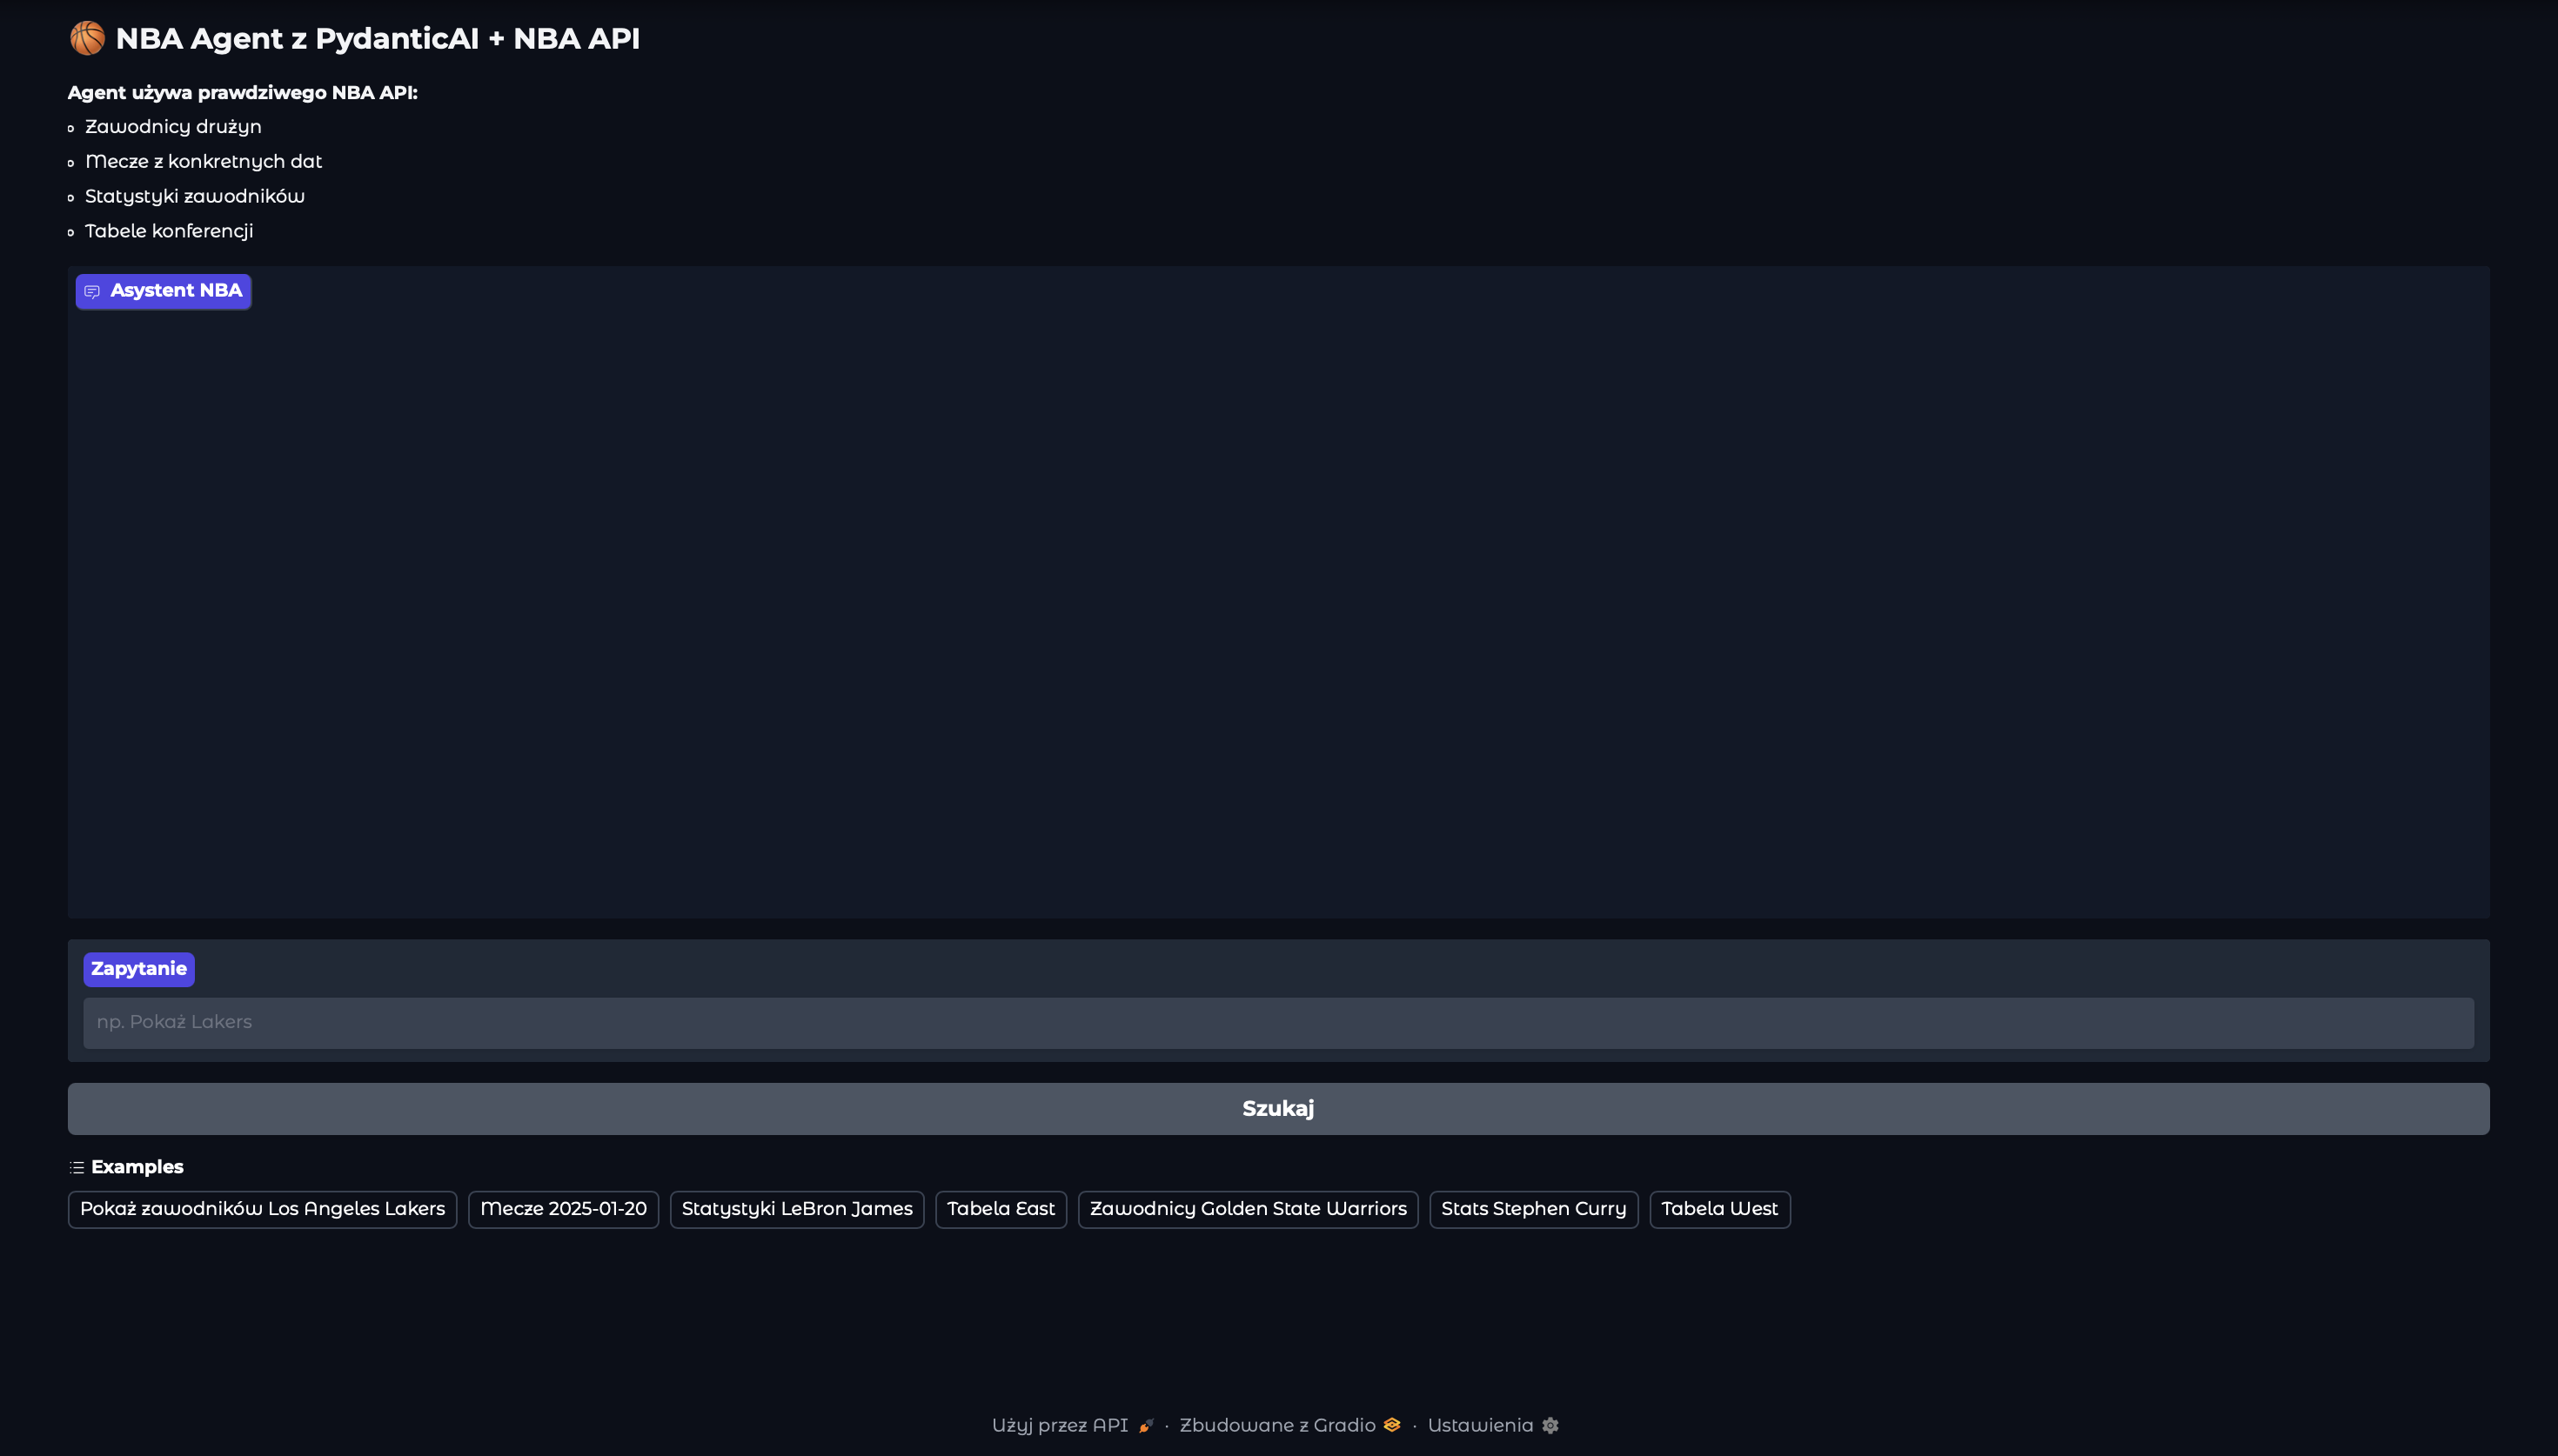/

Utworzyłem graficzny interfejs użytkownika w bibliotece Gradio, który pozwala w prosty sposób korzystać z agenta NBA. Interfejs składa się z okna czatu, pola tekstowego oraz przycisku wywołującego zapytania.
Najważniejsze elementy:
Gr.Chatbot – wyświetla całą rozmowę z agentem w formie komunikatora.
Textbox – umożliwia wpisanie zapytania (np. „Pokaż Lakers”).
Button – uruchamia funkcję handle_query, która pobiera i zwraca prawdziwe dane NBA.
Gr.Examples – szybkie przykłady zapytań, które użytkownik może kliknąć.
Całość działa wewnątrz komponentu gr.Blocks, dzięki czemu interfejs jest estetyczny, responsywny i gotowy do uruchomienia jako aplikacja webowa. Po wywołaniu demo.launch() pojawia się w pełni interaktywny agent NBA dostępny przez przeglądarkę.

## Wysłanie prompta:

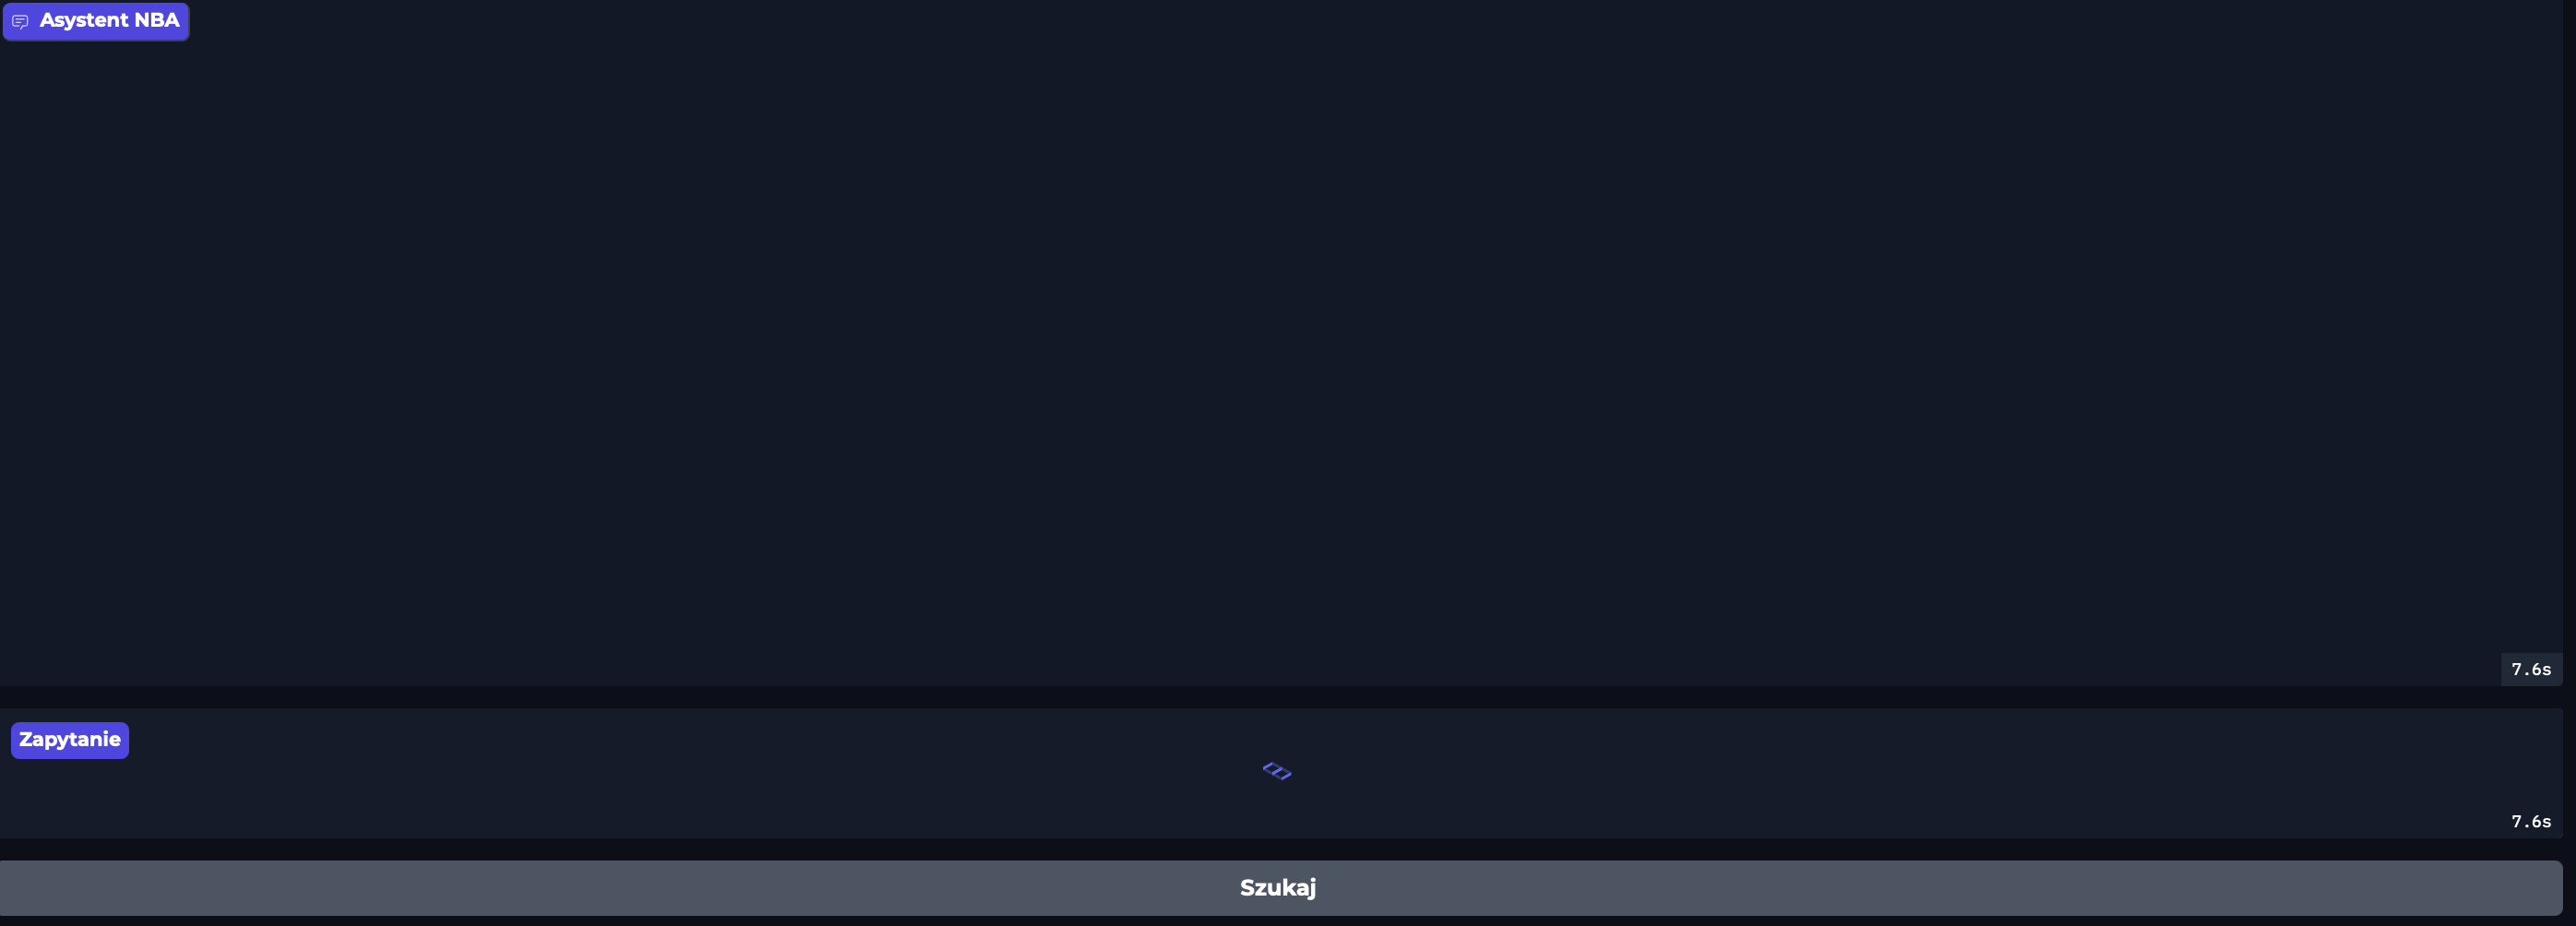

## Tool 1: Pokazanie zawodników konkretnej druzyny:

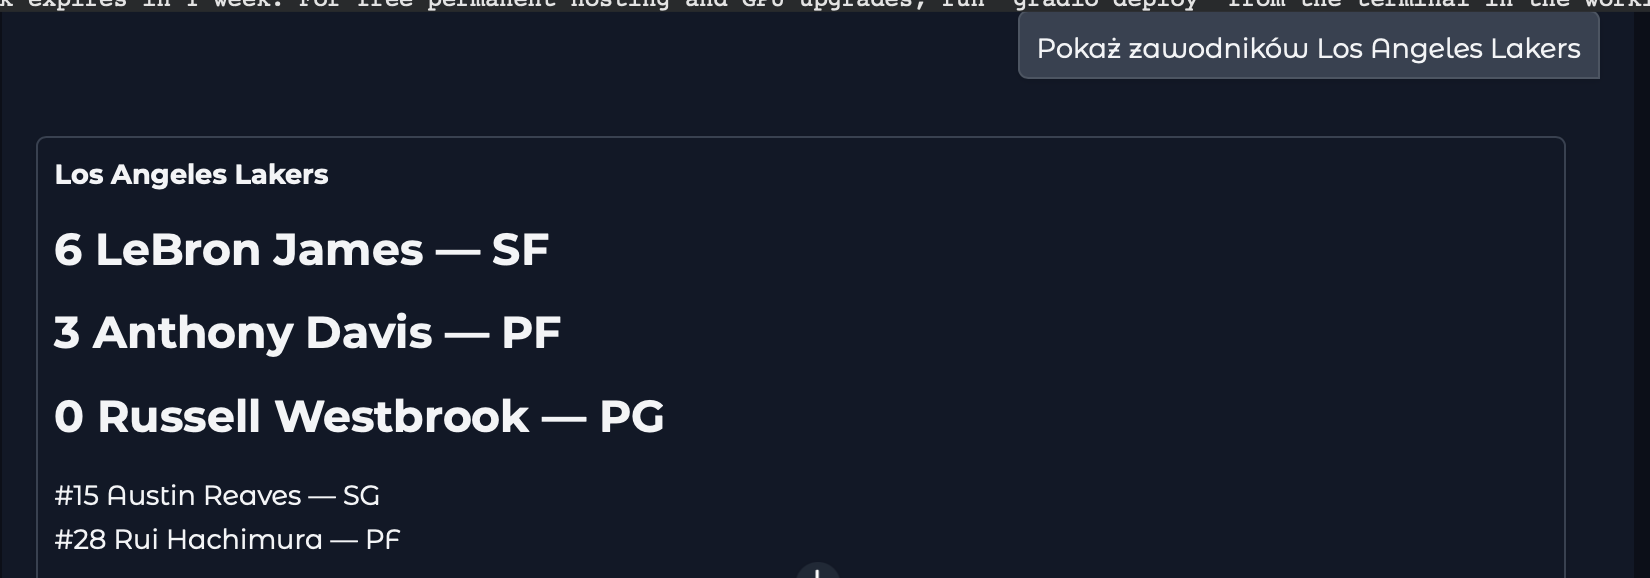

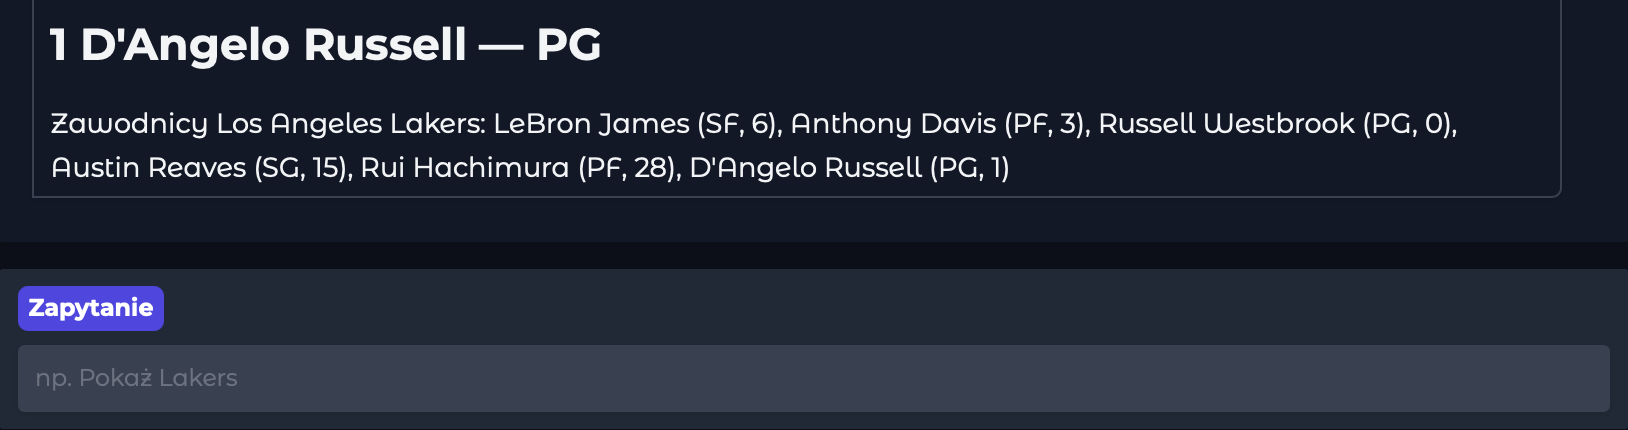

## Tool 2 : Wyświetlanie meczy dla danego dnia:

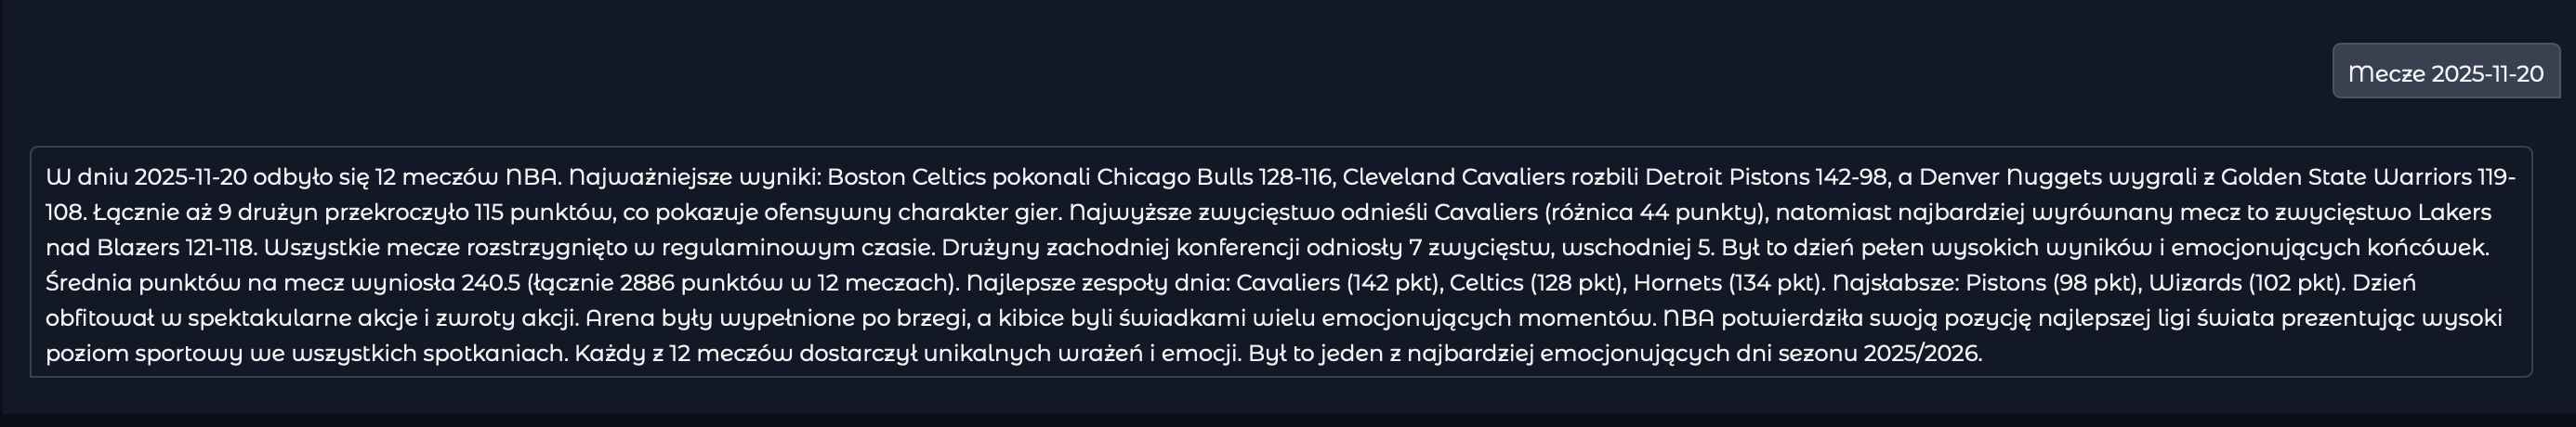

## Tool 3: Wyświetlanie statystyk danego zawodnika:

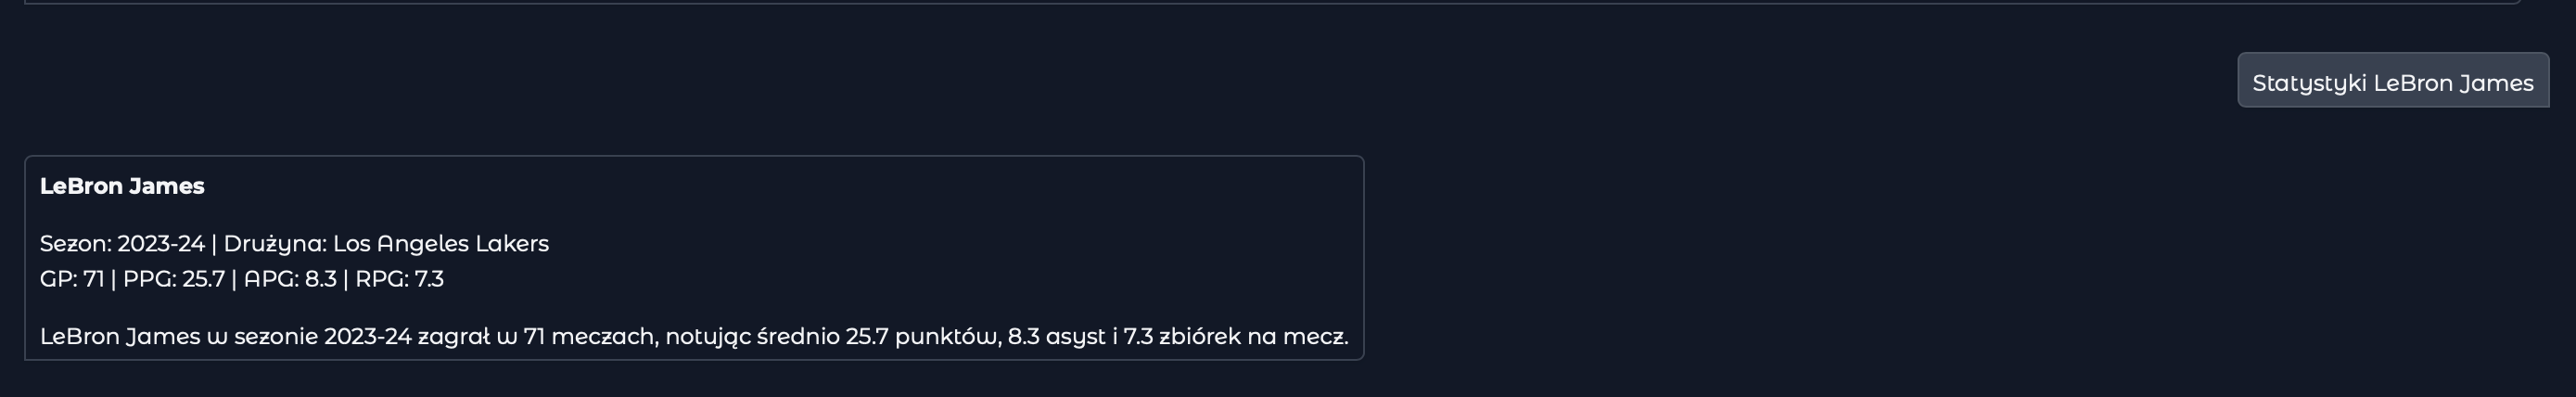

## Tool 4: Wyświetlanie teabeli konferencji albo West/East

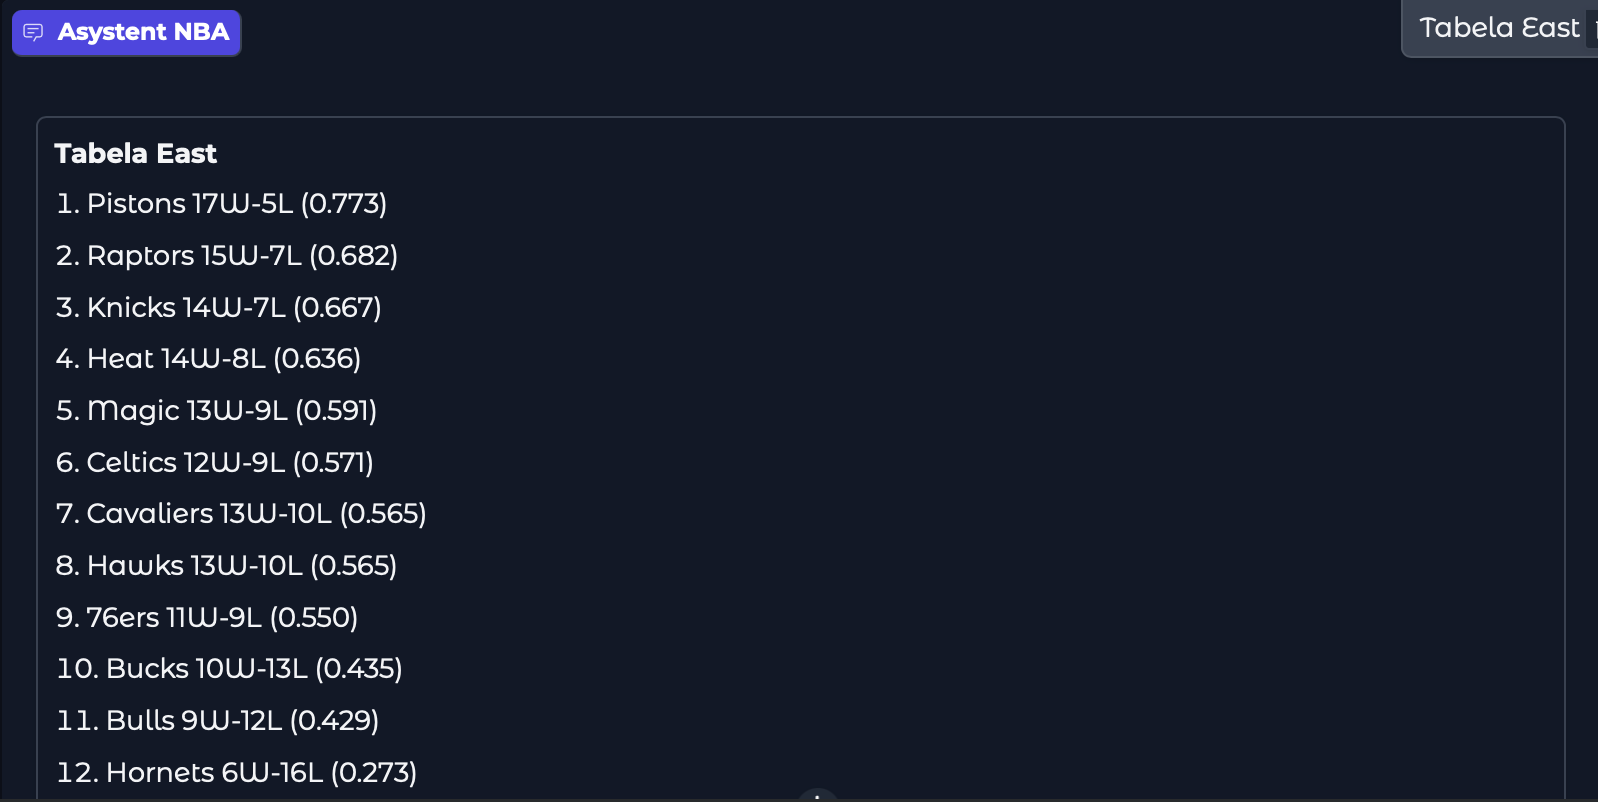


Pokazałem działanie wszystkich czterech narzędzi używanych przez agenta NBA: pobierania zawodników drużyny, meczów z wybranej daty, statystyk zawodnika oraz tabeli konferencji. Każde z tych narzędzi zostało uruchomione na rzeczywistych danych z NBA API, a uzyskane odpowiedzi były zgodne z danymi zwracanymi przez API oraz poprawnie interpretowane przez agenta. Dzięki temu potwierdziłem, że cała logika narzędzi działa prawidłowo, a agent zwraca kompletne i wiarygodne informacje.

## Dodatkowe testy:

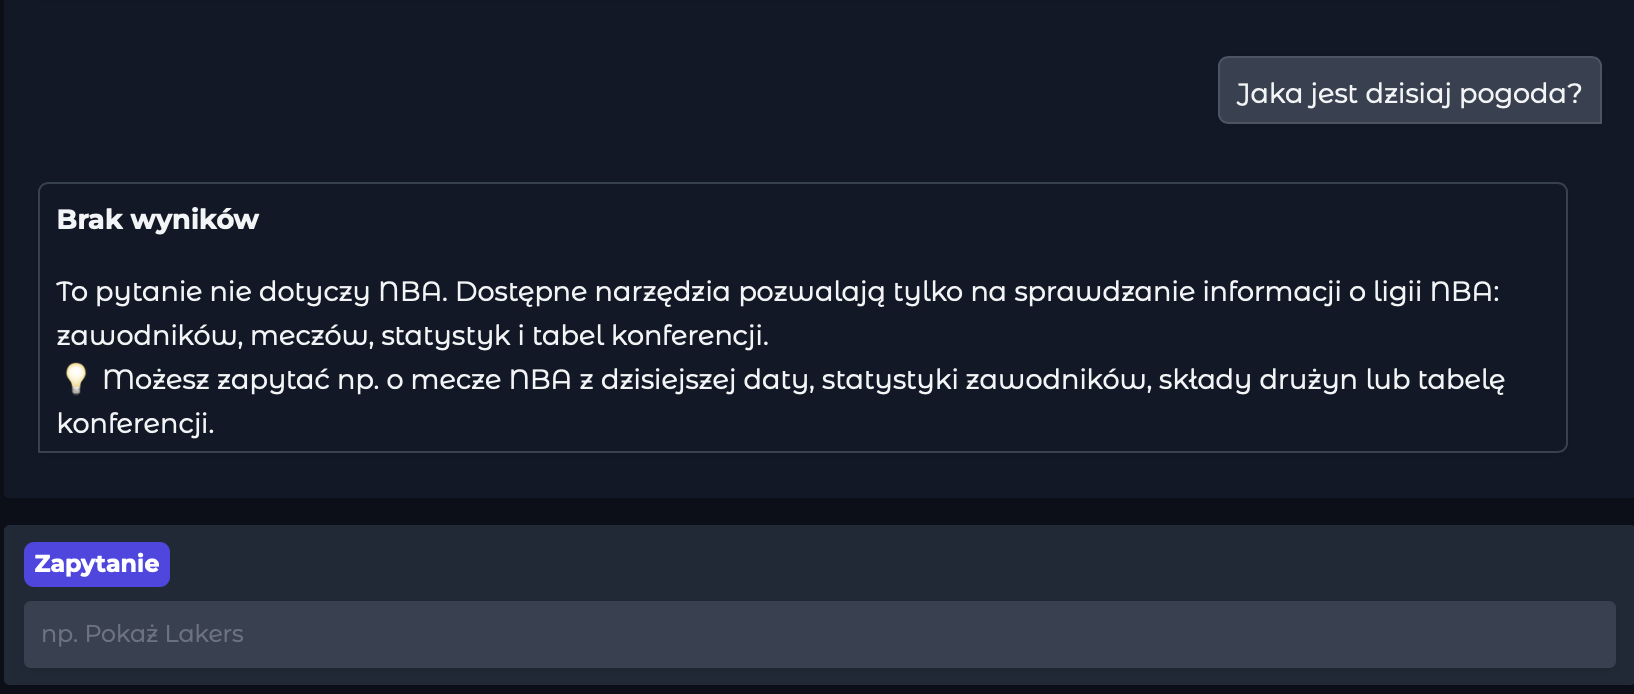

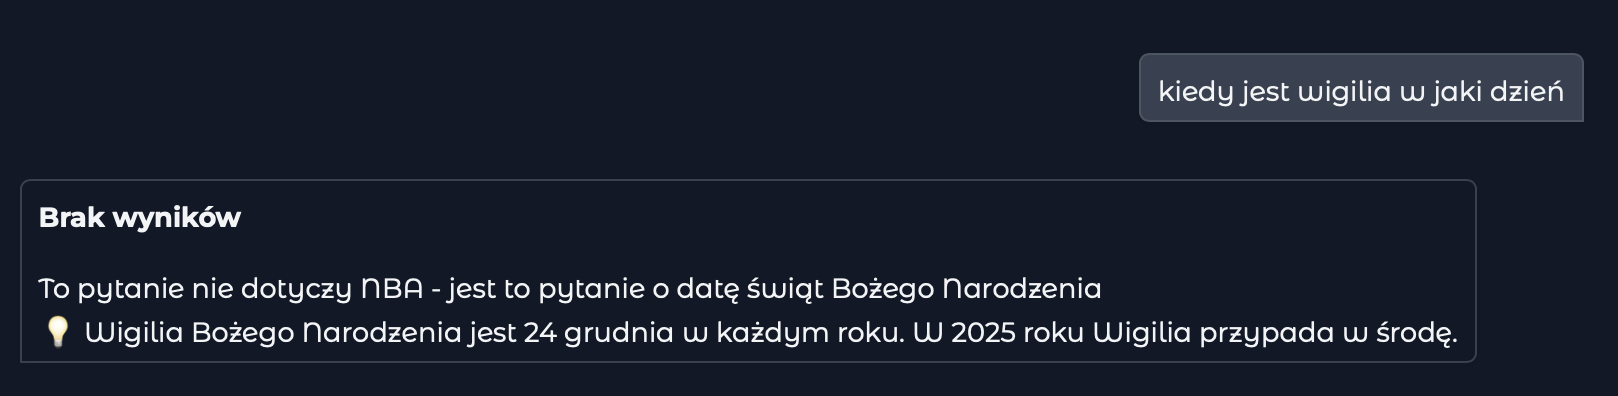

Dodatkowo przetestowałem agenta, zadając pytanie niezwiązane z NBA, np. o pogodę. Agent poprawnie zidentyfikował, że nie posiada danych na ten temat i zwrócił komunikat informujący o braku wyników, zgodnie z założeniami modelu i mechanizmem NoResultsFound. Dzięki temu widać, że agent prawidłowo rozpoznaje zapytania spoza zakresu swoich narzędzi i nie generuje fikcyjnych informacji.

## Wnioski końcowe:

Stworzyłem swój unikalny api key na hugging face i przetestowałem gotowe już rozwiązania, które były już w notebooku. Wybrałem temat NBA, co umożliwia agentowi korzystanie z wielu narzędzi do pobierania danych o zawodnikach, meczach, statystykach oraz tabelach konferencji. Został stworzony kompletny model Pydantic, który waliduje output agenta i zapewnia poprawność typów danych oraz ograniczenia dla niektórych pól (np. liczba punktów, pozycja w tabeli, numer koszulki).
Zaimplementowałem cztery narzędzia (tools), wszystkie zwracające dane w formacie kompatybilnym z modelem Pydantic:
Pobieranie zawodników drużyny,
Pobieranie meczów z określonej daty,
Pobieranie statystyk zawodnika,
Pobieranie tabeli konferencji.
Następnie skonfigurowałem agenta PydanticAI, łącząc model językowy HuggingFace z narzędziami oraz określając instrukcje systemowe, które zapewniają, że agent zawsze korzysta z prawdziwych danych i zwraca walidowany output.
Stworzyłem również interaktywny interfejs Gradio, który pozwala użytkownikowi wprowadzać zapytania, wyświetla czat i prezentuje dane w estetycznej, czytelnej formie.
Podczas testów potwierdziłem, że agent prawidłowo wywołuje wszystkie cztery narzędzia, zwraca poprawne i kompletne dane zgodne z modelem Pydantic oraz odpowiednio reaguje na zapytania spoza zakresu (np. pytania o pogodę), zwracając komunikat NoResultsFound.
Podsumowując, wszystkie wymagania z zadania zostały spełnione: wybrano odpowiedni temat, zdefiniowano model Pydantic, zaimplementowano więcej niż dwa narzędzia, skonfigurowano agenta, zbudowano interfejs Gradio oraz przetestowano działanie i poprawność zwracanych danych.